In [3]:
library(monocle3)
library(Seurat)
library(dplyr)
library(biomaRt)
library(stringr)
library(SCORPIUS)
library(ggplot2)
library(cowplot)
library(RColorBrewer)
library(scales)

In [4]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"

In [5]:
integrated_meta = read.table(paste(out, "integrated_annotations.txt", sep = ""))

In [6]:
f = paste(out, "obj.integrated.frazer.melton", sep = "")
load(f, verbose = T)

Loading objects:
  integrated


In [7]:
integrated = integrated

In [9]:
library(Seurat)

In [10]:
integrated

An object of class Seurat 
60358 features across 112509 samples within 2 assays 
Active assay: RNA (58358 features)
 1 other assay present: integrated
 2 dimensional reductions calculated: pca, umap

In [13]:
table(integrated@meta.data$Stage)


   3    4    5    6 
7982 6960 4193 5186 

In [7]:
Idents(integrated) <- "integrated_snn_res.0.05"

In [8]:
integrated@meta.data$major_cell_population = integrated_meta[match(rownames(integrated@meta.data), rownames(integrated_meta)), "major_cell_population"] 
integrated@meta.data$minor_cell_population = integrated_meta[match(rownames(integrated@meta.data), rownames(integrated_meta)), "minor_cell_population"] 

In [9]:
integrated@meta.data$study = "Frazer"
integrated@meta.data[integrated@meta.data$orig.ident == "x1", ]$study = "Melton"

# S5

In [22]:
Idents(integrated) <- "integrated_snn_res.0.05"

In [36]:
integrated@meta.data$subject_collapsed = integrated@meta.data$label2
#matched fresh frozen
integrated@meta.data[integrated@meta.data$subject_collapsed == "C0005" & ! is.na(integrated@meta.data$subject_collapsed) , "subject_collapsed"] = "C0005_PPC_PPC027"
integrated@meta.data[integrated@meta.data$subject_collapsed == "Q0115" & ! is.na(integrated@meta.data$subject_collapsed) , "subject_collapsed"] = "Q0115_PPC_PPC023"
integrated@meta.data[integrated@meta.data$subject_collapsed == "T104" & ! is.na(integrated@meta.data$subject_collapsed) , "subject_collapsed"]  = "T104_PPC_PPC034"
integrated@meta.data[integrated@meta.data$subject_collapsed == "T600" & ! is.na(integrated@meta.data$subject_collapsed) , "subject_collapsed"]  = "T600_PPC_PPC029"

#only frozen
integrated@meta.data[integrated@meta.data$subject_collapsed == "P0353" & ! is.na(integrated@meta.data$subject_collapsed) , "subject_collapsed"]  = "P0353_PPC_PPC150"
integrated@meta.data[integrated@meta.data$subject_collapsed == "T151" & ! is.na(integrated@meta.data$subject_collapsed) , "subject_collapsed"]   = "T151_PPC_PPC051"
integrated@meta.data[integrated@meta.data$subject_collapsed == "S02307" & ! is.na(integrated@meta.data$subject_collapsed) , "subject_collapsed"] = "S02307_PPC_PPC134"

In [37]:
integrated@meta.data$name2plot <- integrated@meta.data$subject_collapsed
integrated@meta.data[! is.na(integrated@meta.data$name2plot), "name2plot"] = str_split_fixed(integrated@meta.data[! is.na(integrated@meta.data$name2plot), "name2plot"], "_", 3)[, 3] 
integrated@meta.data[is.na(integrated@meta.data$name2plot), "name2plot"] = "SC-B study cells"

In [38]:
#handle iPSC
integrated@meta.data[integrated@meta.data$subject_collapsed == "T104_iPSC_PPC034" & ! is.na(integrated@meta.data$subject_collapsed) , "name2plot"] = "iPSC_PPC034"

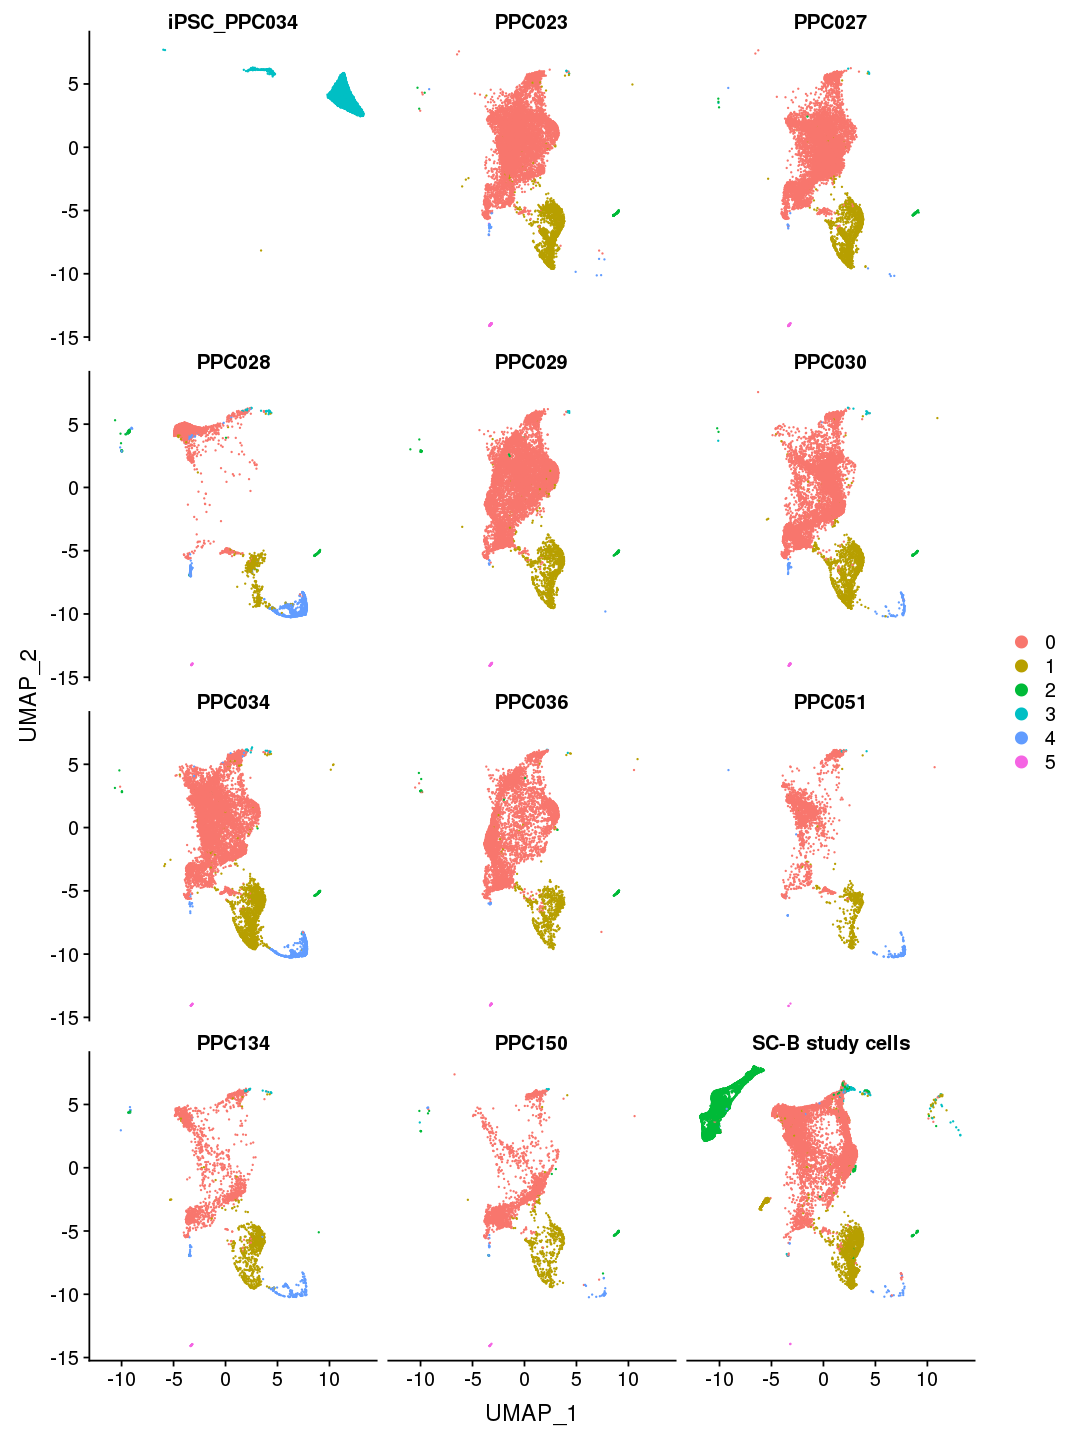

In [39]:
options(repr.plot.width = 9, repr.plot.height = 12)

DimPlot(integrated, split.by = "name2plot", ncol = 3) 

# Figure 3A

In [10]:
PlotUMAP <- function(obj, annotate, lX, lY, text_width, n.col, plot_leg = FALSE, cols2use = NULL){

    options(repr.plot.width = 3, repr.plot.height = 3)
    par(mar = c(4, 4, 1, 1), xpd=FALSE)
    umap = as.data.frame(Embeddings(obj[["umap"]]))
    umap$clusters = obj@meta.data[match(rownames(umap), rownames(obj@meta.data)), annotate]
    
    qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
    col_vector    = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
    my_color_palette <- hue_pal()(length(unique(umap$clusters)))
    
    if(length(cols2use) > 0){colrs = data.frame(clusters = unique(umap$clusters), color = cols2use)}
    else{colrs = data.frame(clusters = sort(unique(umap$clusters)), color = my_color_palette)}
    umap$color = colrs[match(umap$clusters, colrs$clusters), "color"]
    

    
    plot(umap[, 1], umap[, 2],
         pch = 19, 
         xlab = "UMAP1",
         ylab = "UMAP2",
         col = umap$color,
         cex = .1,
         las = 1)

    if( plot_leg == TRUE){
        legend(lX, lY,
               legend = colrs$clusters,
               col    = colrs$color,
               pch    = rep(16, nrow(colrs)),
               cex=.9,
               bg="transparent",
               box.lty = 0,
               y.intersp = 1.75,
               ncol = n.col,
               x.intersp = 1.15,
               text.width = text_width)
    }
    
    return(colrs)
    
}

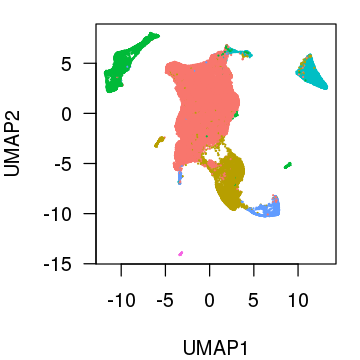

In [13]:
x = PlotUMAP(integrated, "integrated_snn_res.0.05", 3, 13, text_width = 2, n.col = 2, plot_leg = F)

In [14]:
integrated
x = as.data.frame(table(integrated@meta.data$integrated_snn_res.0.05))
x$frac = (x$Freq / sum(x$Freq)) *100
x

An object of class Seurat 
60358 features across 112509 samples within 2 assays 
Active assay: RNA (58358 features)
 1 other assay present: integrated
 2 dimensional reductions calculated: pca, umap

Var1,Freq,frac
<fct>,<int>,<dbl>
0,74303,66.041828
1,15457,13.738456
2,9664,8.589535
3,9135,8.119350
4,3599,3.198855
5,351,0.311975


# Figure 2B

In [15]:
cols = data.frame(celltype = sort(unique(integrated@meta.data$major_cell_population)), col = c("#56ccd8", "#9c0031", "#4bb047", "#c3826c", "#a6cee3", "#5ebd53", "#d984c6", "#ff7f00", "#67c2a5", "#b2e18c",
                                                                                               "#ede99a", "#d49100", "#c9c230", "#a39000", "#827f80", "#e5191b", "#984ea4", "#387cb7", "#f69c9c"))
# colsrowadd = data.frame(celltype = NA, col =)
# cols = rbind(cols, colsrowadd)

In [424]:
write.csv(cols, file = "../Table/celltype_colors.csv")

In [16]:
unique(integrated@meta.data$Assigned_cluster)

[1] NA                 "repl"             "pdx1"             "nkx61"           
 [5] "sc_alpha"         "fev_high_isl_neg" "neurog3"          "sst_hhex"        
 [9] "exo"              "sc_beta"          "sc_ec"            "foxj1"

In [277]:
colsUSE = cols[cols$celltype %in% (unique(integrated@meta.data$Assigned_cluster)), "col" ][c(7, 6, 5, 8, 2, 4, 11, 1, 9, 10, 3)]
colsUSE = c( "#c7c7c7", colsUSE)

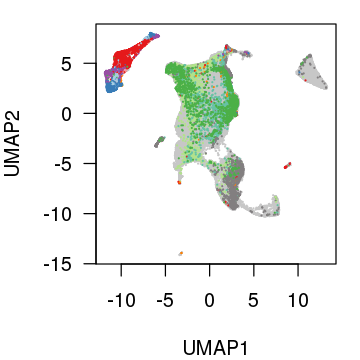

In [175]:
x = PlotUMAP(integrated, "Assigned_cluster", 2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)

# Figure 2C

In [285]:
PlotFractionCellsStudy <- function(){

    options(repr.plot.width = 8, repr.plot.height = 6)
    
    par(mfrow = c(2, 1), mar = c(4, 5, 1, 1))
    data = t(table(integrated@meta.data$integrated_snn_res.0.05, integrated@meta.data$study))
    data = data[c(2, 1), ]
    barplot(data, col = c("#2c6954", "#84d9be"), las = 1, ylab = "N cells", xlab = "Cluster", , ylim = c(0, 80000))

    data = t(table(integrated@meta.data$integrated_snn_res.0.05, integrated@meta.data$Assigned_cluster))
    barplot(data, col = cols[cols$celltype %in% sort(unique(integrated@meta.data$Assigned_cluster)), "col"], las = 1, ylab = "N cells", xlab = "Cluster", ylim = c(0, 12000))
}

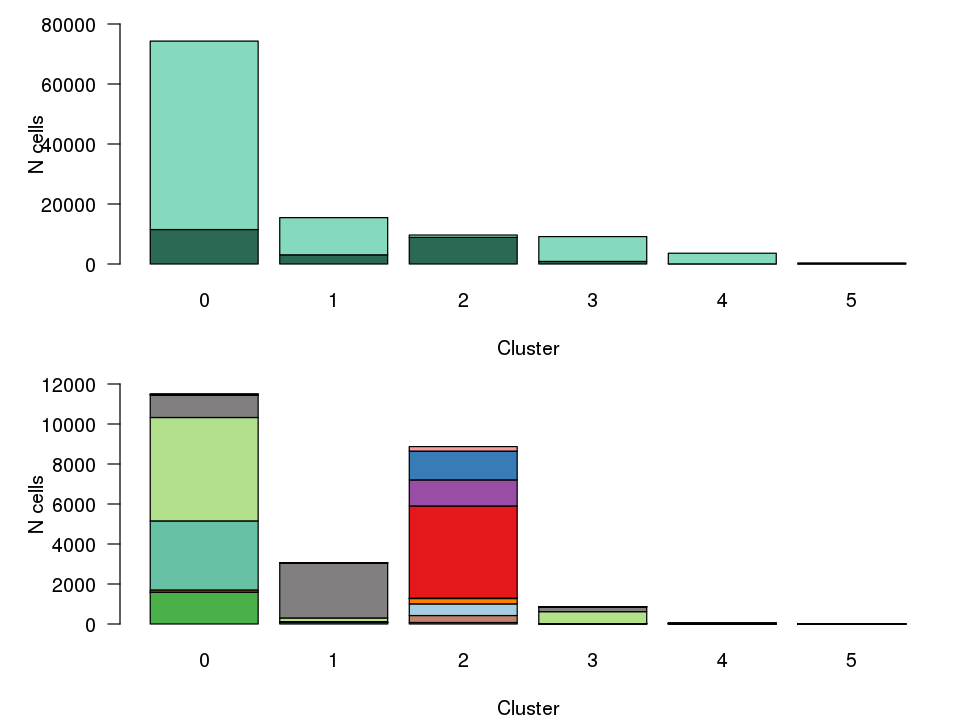

In [286]:
PlotFractionCellsStudy()

# Figure 2D

In [417]:
PlotGeneExpression <- function(obj){
    options(repr.plot.width = 3, repr.plot.height = 3)
    p <- FeaturePlot(obj, features = c("POU5F1", "PDX1", "NKX6-1", "CHGA", "INS", "PLVAP", "TOP2A", "COL3A1"),
                pt.size = .0001, min.cutoff = c(0, 0, 0, 1, 1, 1, 0, 0), max.cutoff = c(1.5, 1.5, 1.5, 50, 50, 2, 3, 1),
                combine = FALSE, cols = c("#c2c2c210","#910000"))

    for(i in 1:length(p)) {

        p[[i]] <- p[[i]] + NoLegend() + FontSize(main = 6) + NoAxes()

    }

    cowplot::plot_grid(plotlist = p, ncol = 3)
}


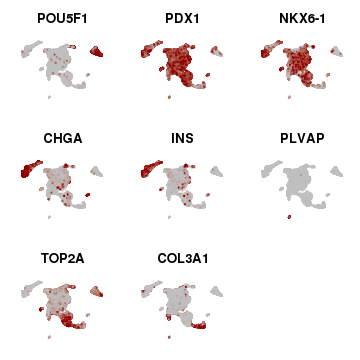

In [294]:
PlotGeneExpression(integrated)

# Figure 2E

In [18]:
pseudotime_meta = read.table(paste(out, "integrated_cluster0_pseudotime.txt", sep = ""))

In [19]:
integrated@meta.data$pseudotime      = as.numeric(pseudotime_meta[match(rownames(integrated@meta.data), rownames(pseudotime_meta)), "pseudotime"])
integrated@meta.data$pseudotime_bins = pseudotime_meta[match(rownames(integrated@meta.data), rownames(pseudotime_meta)), "quants"] 

In [20]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
f = paste(out, "obj.integrated.frazer.melton_cluster0_seurat_obj", sep = "")
load(f, verbose = T)

Loading objects:
  integrated.C0_test


In [21]:
load(paste(out, "obj.integrated.frazer.melton_cluster0_pseudotime", sep = ""))

In [22]:
cols = data.frame(celltype = sort(unique(integrated@meta.data$major_cell_population)), col = c("#56ccd8", "#9c0031", "#4bb047", "#c3826c", "#a6cee3", "#5ebd53", "#d984c6", "#ff7f00", "#67c2a5", "#b2e18c",
                                                                                               "#ede99a", "#d49100", "#c9c230", "#a39000", "#827f80", "#e5191b", "#984ea4", "#387cb7", "#f69c9c"))
# colsrowadd = data.frame(celltype = NA, col =)
# cols = rbind(cols, colsrowadd)

In [23]:
colsUSE = cols[cols$celltype %in% (unique(integrated.C0_test@meta.data$Assigned_cluster)), "col" ][c(5, 6, 4, 3, 7, 1, 9, 8, 2)]
colsUSE = c( "#c7c7c7", colsUSE)

# Supplemental Figure for Cluster 0 

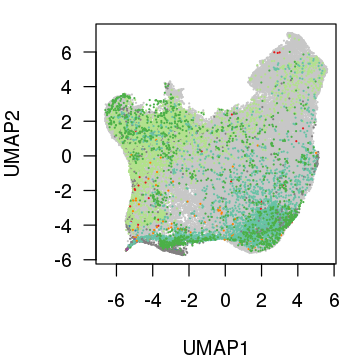

In [24]:
x = PlotUMAP(integrated.C0_test, "Assigned_cluster", -2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)

In [26]:
cds

class: cell_data_set 
dim: 58358 74303 
metadata(1): cds_version
assays(1): counts
rownames(58358): DDX11L1 WASH7P ... RNF212B TMEM269
rowData names(2): id gene_short_name
colnames(74303): AATGGAACACTGAGGA-1 AGATCCATCGAAACAA-1 ...
  x1_S6c_b2.bcCDKI x1_S6c_b2.bcCKKM
colData names(35): orig.ident nCount_RNA ... RNA_snn_res.0.3
  Size_Factor
reducedDimNames(2): PCA UMAP
spikeNames(0):

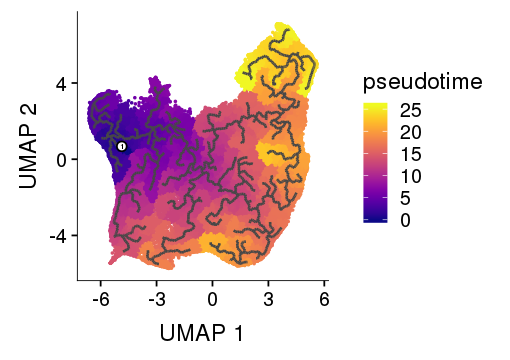

In [27]:
options(repr.plot.width = 4.25, repr.plot.height = 3)
plot_cells(cds, 
           color_cells_by = "pseudotime", 
           label_cell_groups=FALSE, 
           label_leaves=FALSE,
           label_branch_points=FALSE,
           graph_label_size=1.5)

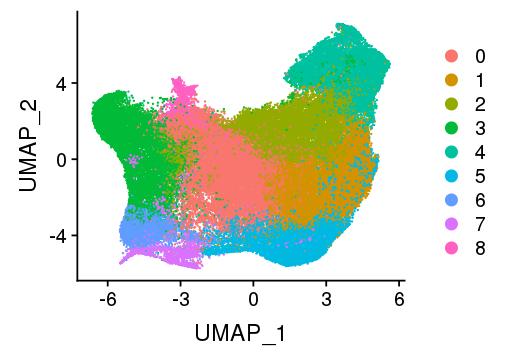

In [28]:
options(repr.plot.width = 4.25, repr.plot.height = 3)
DimPlot(integrated.C0_test, group.by = "RNA_snn_res.0.3")

In [29]:
integrated.C0_test@meta.data$subject_collapsed = integrated.C0_test@meta.data$label2
#matched fresh frozen
integrated.C0_test@meta.data[integrated.C0_test@meta.data$subject_collapsed == "C0005" & ! is.na(integrated.C0_test@meta.data$subject_collapsed) , "subject_collapsed"] = "C0005_PPC_PPC027"
integrated.C0_test@meta.data[integrated.C0_test@meta.data$subject_collapsed == "Q0115" & ! is.na(integrated.C0_test@meta.data$subject_collapsed) , "subject_collapsed"] = "Q0115_PPC_PPC023"
integrated.C0_test@meta.data[integrated.C0_test@meta.data$subject_collapsed == "T104" & ! is.na(integrated.C0_test@meta.data$subject_collapsed) , "subject_collapsed"]  = "T104_PPC_PPC034"
integrated.C0_test@meta.data[integrated.C0_test@meta.data$subject_collapsed == "T600" & ! is.na(integrated.C0_test@meta.data$subject_collapsed) , "subject_collapsed"]  = "T600_PPC_PPC029"

#only frozen
integrated.C0_test@meta.data[integrated.C0_test@meta.data$subject_collapsed == "P0353" & ! is.na(integrated.C0_test@meta.data$subject_collapsed) , "subject_collapsed"]  = "P0353_PPC_PPC150"
integrated.C0_test@meta.data[integrated.C0_test@meta.data$subject_collapsed == "T151" & ! is.na(integrated.C0_test@meta.data$subject_collapsed) , "subject_collapsed"]   = "T151_PPC_PPC051"
integrated.C0_test@meta.data[integrated.C0_test@meta.data$subject_collapsed == "S02307" & ! is.na(integrated.C0_test@meta.data$subject_collapsed) , "subject_collapsed"] = "S02307_PPC_PPC134"


In [30]:
library(stringr)

In [31]:
integrated.C0_test@meta.data$name2plot <- integrated.C0_test@meta.data$subject_collapsed
integrated.C0_test@meta.data[! is.na(integrated.C0_test@meta.data$name2plot), "name2plot"] = str_split_fixed(integrated.C0_test@meta.data[! is.na(integrated.C0_test@meta.data$name2plot), "name2plot"], "_", 3)[, 3] 
integrated.C0_test@meta.data[is.na(integrated.C0_test@meta.data$name2plot), "name2plot"] = "SC-B study cells"

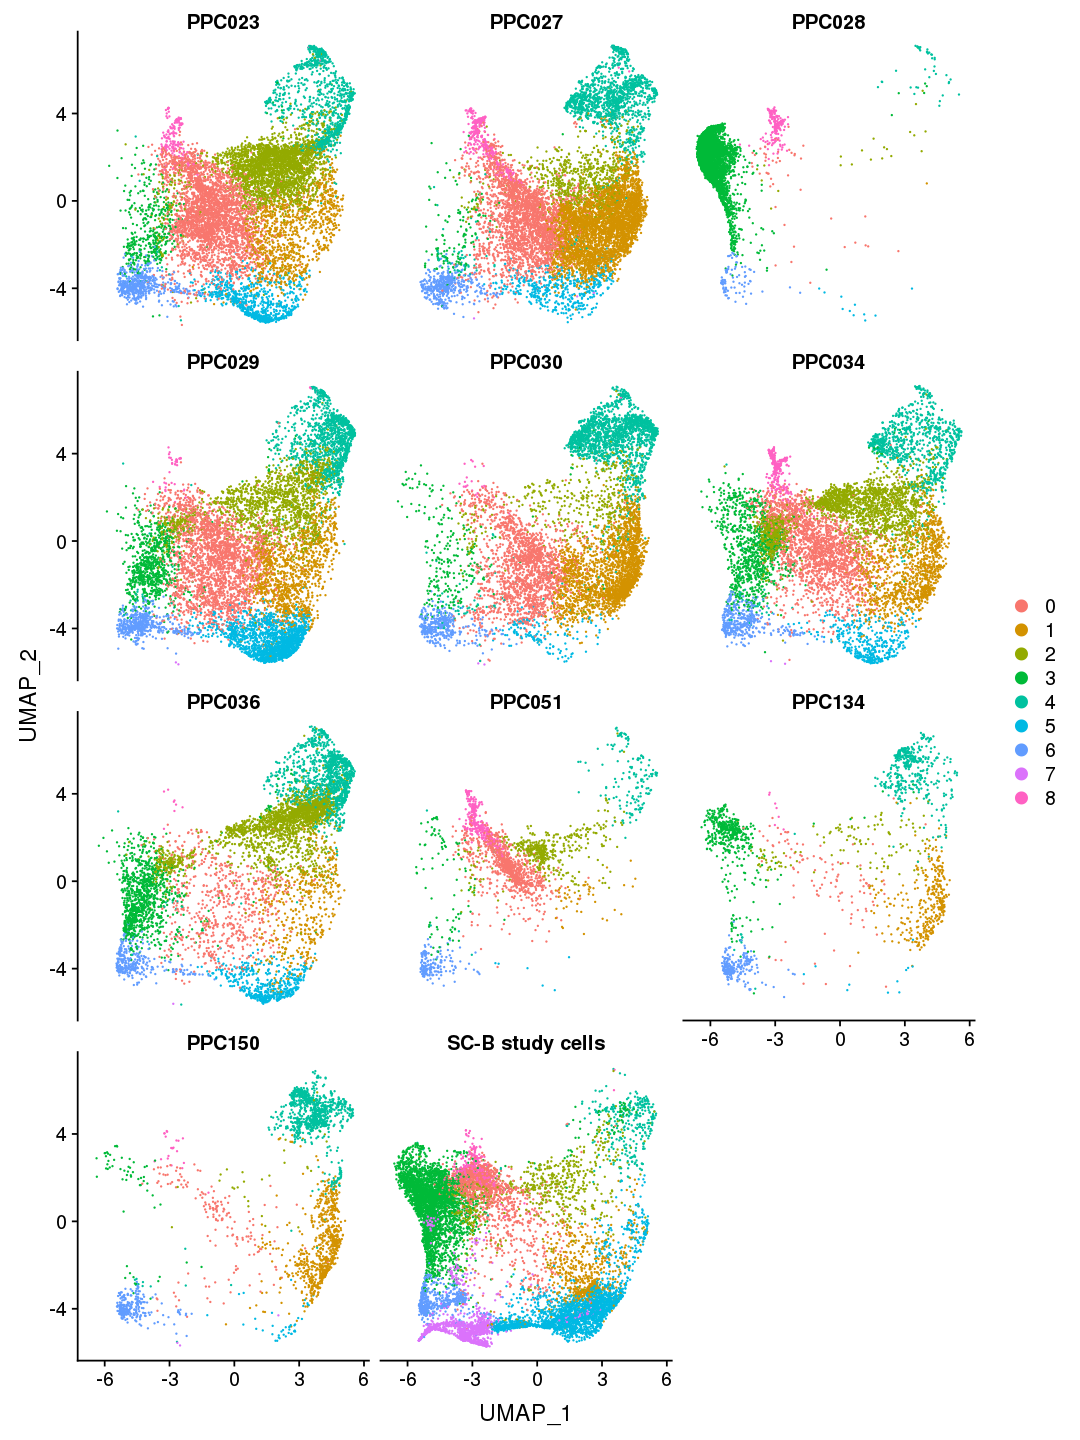

In [32]:
options(repr.plot.width = 9, repr.plot.height = 12)

DimPlot(integrated.C0_test, split.by = "name2plot", ncol = 3) 

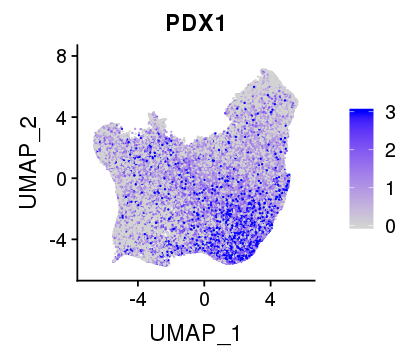

In [46]:
options(repr.plot.width = 3.5, repr.plot.height = 3)
FeaturePlot(integrated.C0_test, "PDX1", max.cutoff = 3)

In [34]:
fig.out = "../Figures/Manuscript_V04/Figure_S4_"
png(paste(fig.out, "UMAP_PDX1exo_cluster0.png"), width = 3.5, height = 3, units = "in", res = 1200)
FeaturePlot(integrated.C0_test, "PDX1", max.cutoff = 3)
dev.off()

png 
  2

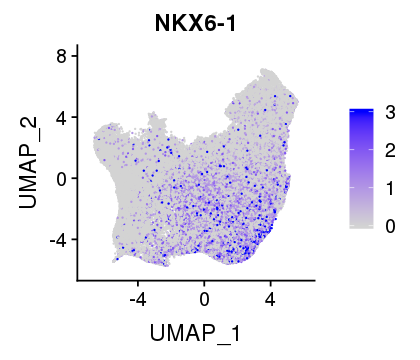

In [47]:
options(repr.plot.width = 3.5, repr.plot.height = 3)
FeaturePlot(integrated.C0_test, "NKX6-1", max.cutoff = 3)

In [35]:
fig.out = "../Figures/Manuscript_V04/Figure_S4_"
png(paste(fig.out, "UMAP_NKXexo_cluster0.png"), width = 3.5, height = 3, units = "in", res = 1200)
FeaturePlot(integrated.C0_test, "NKX6-1", max.cutoff = 3)
dev.off()

png 
  2

In [36]:
genes = c("PDX1", "NKX6-1")
melton_pdx_cells_no4   = rownames(pData(cds)[pData(cds)$Assigned_cluster == "pdx1" & pData(cds)$study == "Melton" & (! pData(cds)$RNA_snn_res.0.3 %in% c("4")), ])
melton_nkx61_cells_no4 = rownames(pData(cds)[pData(cds)$Assigned_cluster == "nkx61" & pData(cds)$study == "Melton" & (! pData(cds)$RNA_snn_res.0.3 %in% c("4")), ])
melton_exo_cells_no4   = rownames(pData(cds)[pData(cds)$Assigned_cluster == "exo" & pData(cds)$study == "Melton" & (! pData(cds)$RNA_snn_res.0.3 %in% c("4")), ])
frazer_ppc_cells_no4   = rownames(pData(cds)[pData(cds)$study == "Frazer"  & (! pData(cds)$RNA_snn_res.0.3 %in% c("4")), ])

genes2plot_melton_pdx_cells_no4   = cds[rowData(cds)$gene_short_name %in% genes, melton_pdx_cells_no4]
genes2plot_melton_nkx61_cells_no4 = cds[rowData(cds)$gene_short_name %in% genes, melton_nkx61_cells_no4]
genes2plot_melton_exo_cells_no4   = cds[rowData(cds)$gene_short_name %in% genes, melton_exo_cells_no4  ]
genes2plot_frazer_ppc_cells_no4   = cds[rowData(cds)$gene_short_name %in% genes, frazer_ppc_cells_no4  ]

In [37]:
genes = c("PDX1", "NKX6-1")
melton_pdx_cells   = rownames(pData(cds)[pData(cds)$Assigned_cluster == "pdx1" & pData(cds)$study == "Melton", ])
melton_nkx61_cells = rownames(pData(cds)[pData(cds)$Assigned_cluster == "nkx61" & pData(cds)$study == "Melton", ])
melton_exo_cells  = rownames(pData(cds)[pData(cds)$Assigned_cluster == "exo" & pData(cds)$study == "Melton", ])
frazer_ppc_cells  = rownames(pData(cds)[pData(cds)$study == "Frazer", ])

genes2plot_melton_pdx_cells = cds[rowData(cds)$gene_short_name %in% genes, melton_pdx_cells]
genes2plot_melton_nkx61_cells = cds[rowData(cds)$gene_short_name %in% genes, melton_nkx61_cells]
genes2plot_melton_exo_cells = cds[rowData(cds)$gene_short_name %in% genes, melton_exo_cells]
genes2plot_frazer_ppc_cells = cds[rowData(cds)$gene_short_name %in% genes, frazer_ppc_cells]

In [38]:
genes2plot   = cds[rowData(cds)$gene_short_name %in% genes, ]

cells2use   = rownames(pData(cds)[ (! pData(cds)$RNA_snn_res.0.3 %in% c("4")), ])
genes2plot_no4   = cds[rowData(cds)$gene_short_name %in% genes, cells2use]

In [39]:
library(ggplot2)

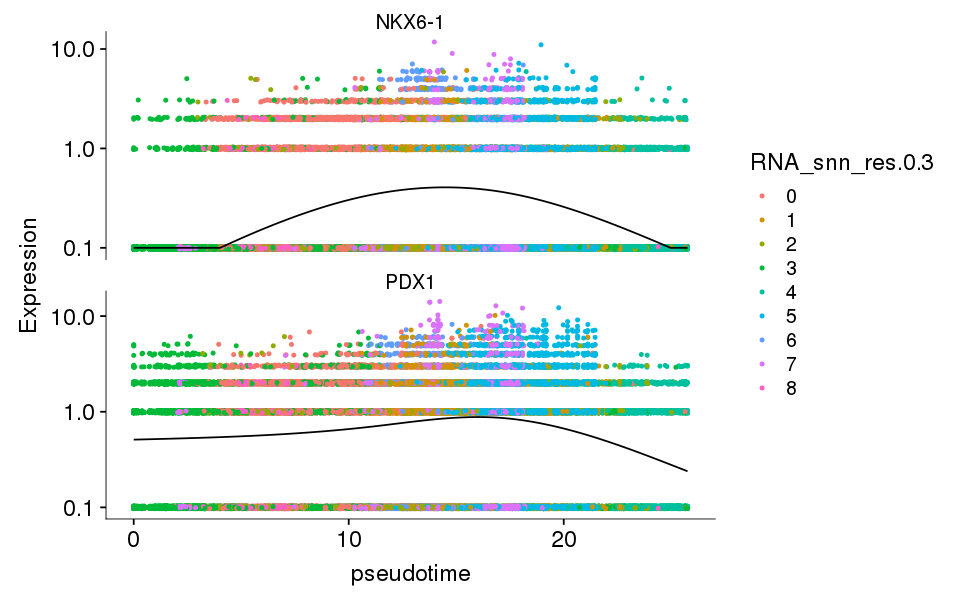

In [40]:
options(repr.plot.width = 8, repr.plot.height = 5)
plot_genes_in_pseudotime(genes2plot,color_cells_by="RNA_snn_res.0.3", min_expr=0.1) +
    theme(text = element_text(size=14), axis.text.x = element_text(size=14), axis.text.y = element_text(size=14))


In [42]:
fig.out = "../Figures/Manuscript_V04/Figure_S4_"
png(paste(fig.out, "Clusters_over_pseudotime_scatter.png"), width = 4, height = 2.5, units = "in", res = 1200)
plot_genes_in_pseudotime(genes2plot,color_cells_by="RNA_snn_res.0.3", min_expr=0.1) +
    theme(text = element_text(size=14), axis.text.x = element_text(size=14), axis.text.y = element_text(size=14))
dev.off()

png 
  2

# Main Figure 2D

In [27]:
integrated.C0_test_no4 = subset(integrated.C0_test, idents = c(0, 1, 2, 3, 5, 6, 7, 8))

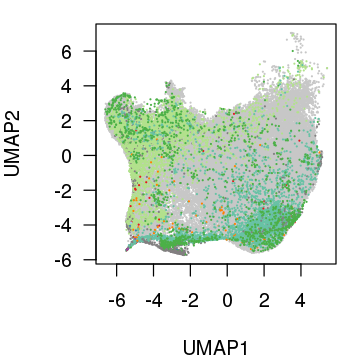

In [28]:
x = PlotUMAP(integrated.C0_test_no4, "Assigned_cluster", -2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)

In [ ]:
png(paste(out, "UMAP_byCell_cluster0.png"), width = 3, height = 3, units = "in", res = 1200)
x = PlotUMAP(integrated.C0_test, "Assigned_cluster", -2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)
dev.off()

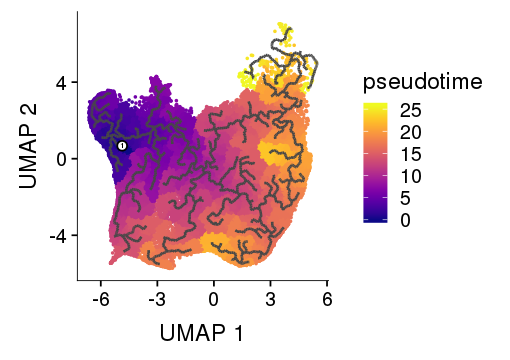

In [31]:
cells2use   = rownames(pData(cds)[ (! pData(cds)$RNA_snn_res.0.3 %in% c("4")), ])

options(repr.plot.width = 4.25, repr.plot.height = 3)
plot_cells(cds[, cells2use], 
           color_cells_by = "pseudotime", 
           label_cell_groups=FALSE, 
           label_leaves=FALSE,
           label_branch_points=FALSE,
           graph_label_size=1.5)

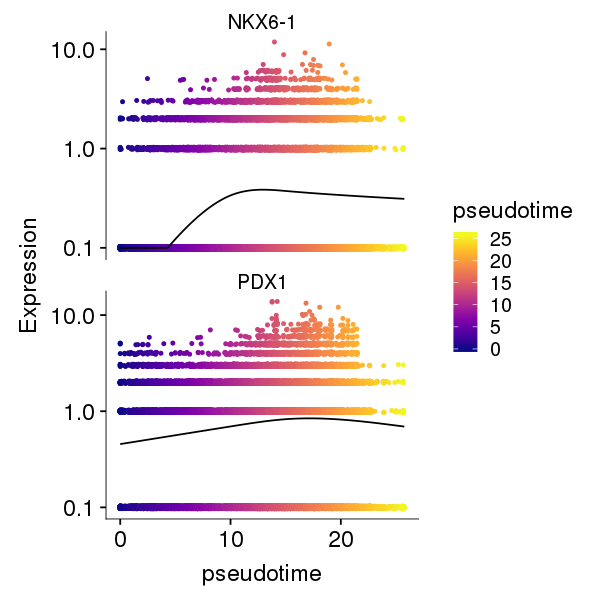

In [36]:
options(repr.plot.width = 5, repr.plot.height = 5)
plot_genes_in_pseudotime(genes2plot_no4,color_cells_by="pseudotime", min_expr=0.1) +
#     scale_color_manual(values = c("#ede99a", "#d49100","#c9c230", "#a39000"), guide = FALSE) +
    theme(text = element_text(size=14), axis.text.x = element_text(size=14), axis.text.y = element_text(size=14))

In [46]:
fig.out = "../Figures/Manuscript_V04/Figure_S4_"
png(paste(fig.out, "Expression_over_pseudotime.png"), width = 2.5, height = 1.25, units = "in", res = 1200)
options(repr.plot.width = 5, repr.plot.height = 5)
plot_genes_in_pseudotime(genes2plot_no4,color_cells_by="pseudotime", min_expr=0.1) +
#     scale_color_manual(values = c("#ede99a", "#d49100","#c9c230", "#a39000"), guide = FALSE) +
    theme(text = element_text(size=6), axis.text.x = element_text(size=6), axis.text.y = element_text(size=6))
dev.off()

png 
  2

# Figure 2F

In [380]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
f = paste(out, "obj.integrated.frazer.melton_cluster1_seurat_obj", sep = "")
load(f, verbose = T)

Loading objects:
  integrated.C1


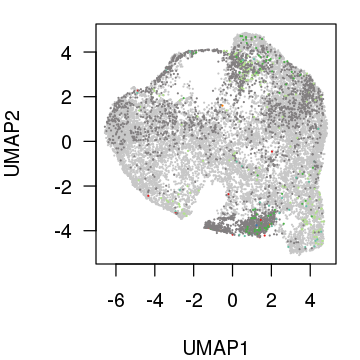

In [400]:
# cols[cols$celltype %in% (unique(integrated.C1@meta.data$Assigned_cluster)), "celltype"]
colsUSE = cols[cols$celltype %in% (unique(integrated.C1@meta.data$Assigned_cluster)), "col" ][c(6, 5, 4, 7, 3, 2, 1, 8)]
colsUSE = c( "#c7c7c7", colsUSE)
x = PlotUMAP(integrated.C1, "Assigned_cluster", -2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)

# Figure 2G

In [379]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
f = paste(out, "obj.integrated.frazer.melton_cluster2_seurat_obj", sep = "")
load(f, verbose = T)

Loading objects:
  integrated.C2


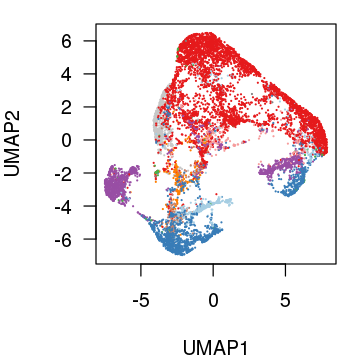

In [404]:
# cols[cols$celltype %in% (unique(integrated.C2@meta.data$Assigned_cluster)), "celltype"]
colsUSE = cols[cols$celltype %in% (unique(integrated.C2@meta.data$Assigned_cluster)), "col" ][c(5, 7, 2, 4, 10, 6, 8, 9, 3, 1)]
colsUSE = c( "#c7c7c7", colsUSE)
x = PlotUMAP(integrated.C2, "Assigned_cluster", -2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)

# Figure 2H

In [47]:
c4_cells = rownames(integrated.C0_test@meta.data[integrated.C0_test@meta.data$RNA_snn_res.0.3 == "4" & integrated.C0_test@meta.data$study == "Frazer", ])
integrated@meta.data$major_cell_population_updated = integrated@meta.data$major_cell_population
integrated@meta.data[rownames(integrated@meta.data) %in% c4_cells , "major_cell_population_updated"] = "0_PPC_unknown"

In [48]:
cols[cols$celltype %in% c("PPC_early", "PPC_late", "PPC_moderate_1", "PPC_moderate_2"), "col"] = "#42d488"
cols[cols$celltype %in% c("iPSC"), "col"] = "#02592c"

colsUSE = cols[cols$celltype %in% (unique(integrated@meta.data$Assigned_cluster)), "col" ][c(7, 6, 5, 8, 2, 4, 11, 1, 9, 10, 3)]
colsUSE = c( "#c7c7c700", colsUSE)
colsUSE = c( "#69967f", colsUSE) # added 0_PPC_Unknwon cluster 4 cell annotation

colsInt = rbind(data.frame(celltype = "0_PPC_unknown", col = "#7dba9a"), cols)

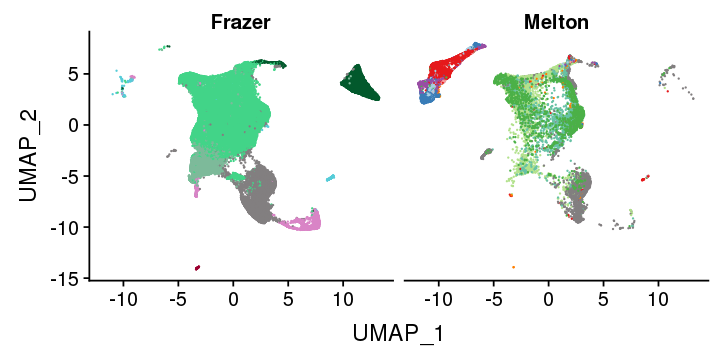

In [49]:
options(repr.plot.width = 6, repr.plot.height = 3)
DimPlot(integrated, group.by = "major_cell_population_updated", split.by = "study", label = F, cols = colsInt$col) + NoLegend()

# Output

In [418]:
# out = "../Figures/Manuscript_V04/Figure_2_"

# png(paste(out, "UMAP_byCluster.png"), width = 3, height = 3, units = "in", res = 1200)
# x = PlotUMAP(integrated, "integrated_snn_res.0.05", 3, 13, text_width = 2, n.col = 2, plot_leg = F)
# dev.off()

# colsUSE = cols[cols$celltype %in% (unique(integrated@meta.data$Assigned_cluster)), "col" ][c(7, 6, 5, 8, 2, 4, 11, 1, 9, 10, 3)]
# colsUSE = c( "#c7c7c7", colsUSE)
# png(paste(out, "UMAP_byMeltonCelltype.png"), width = 3, height = 3, units = "in", res = 1200)
# x = PlotUMAP(integrated, "Assigned_cluster", 2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)
# dev.off()

# pdf(paste(out, "Overall_Barplot.pdf"), width = 8, height = 6)
# PlotFractionCellsStudy()
# dev.off()

png(paste(out, "UMAP_expression.png"), width = 3, height = 3, units = "in", res = 1200)
PlotGeneExpression(integrated)
dev.off()

png 
  2

In [415]:
out = "../Figures/Manuscript_V04/Figure_2_"

png(paste(out, "UMAP_byCell_cluster0.png"), width = 3, height = 3, units = "in", res = 1200)
x = PlotUMAP(integrated.C0_test, "Assigned_cluster", -2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)
dev.off()

png(paste(out, "UMAP_byPseudotime_cluster0_lenged.png"), width = 10, height = 10, units = "in", res = 1200)
plot_cells(cds, color_cells_by = "pseudotime", label_cell_groups=FALSE, label_leaves=FALSE, label_branch_points=FALSE, graph_label_size=1.5)
dev.off()

png(paste(out, "UMAP_byPseudotimeBin_cluster0.png"), width = 3, height = 3, units = "in", res = 1200)
x = PlotUMAP(integrated.C0_test, "pseudotime_quantile", -2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = c("#d49100","#c9c230","#ede99a", "#a39000"))
dev.off()

png(paste(out, "Expression_over_pseudotime_legend.png"), width = 1.25, height = 1.25, units = "in", res = 1200)

plot_genes_in_pseudotime(genes2plot,color_cells_by="pseudotime_quantile", min_expr=0.1) +
    scale_color_manual(values = c("#ede99a", "#d49100","#c9c230", "#a39000"), guide = FALSE) +
    theme(text = element_text(size=6), axis.text.x = element_text(size=6), axis.text.y = element_text(size=6))
dev.off()

png 
  2

In [406]:
out = "../Figures/Manuscript_V04/Figure_2_"

png(paste(out, "UMAP_byCell_cluster1.png"), width = 3, height = 3, units = "in", res = 1200)
# cols[cols$celltype %in% (unique(integrated.C1@meta.data$Assigned_cluster)), "celltype"]
colsUSE = cols[cols$celltype %in% (unique(integrated.C1@meta.data$Assigned_cluster)), "col" ][c(6, 5, 4, 7, 3, 2, 1, 8)]
colsUSE = c( "#c7c7c7", colsUSE)
x = PlotUMAP(integrated.C1, "Assigned_cluster", -2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)
dev.off()

png(paste(out, "UMAP_byPseudotime_cluster2.png"), width = 3, height = 3, units = "in", res = 1200)
# cols[cols$celltype %in% (unique(integrated.C2@meta.data$Assigned_cluster)), "celltype"]
colsUSE = cols[cols$celltype %in% (unique(integrated.C2@meta.data$Assigned_cluster)), "col" ][c(5, 7, 2, 4, 10, 6, 8, 9, 3, 1)]
colsUSE = c( "#c7c7c7", colsUSE)
x = PlotUMAP(integrated.C2, "Assigned_cluster", -2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)
dev.off()


png 
  2

png 
  2

In [50]:
out = "../Figures/Manuscript_V04/Figure_2_"
png(paste(out, "UMAP_bymajor_cell_population.png"), width = 6, height = 3, units = "in", res = 1200)

DimPlot(integrated, group.by = "major_cell_population_updated", split.by = "study", label = F, cols = colsInt$col) + NoLegend()

dev.off()

png 
  2

# Pseudotime on Cluster 0 using Monocle's workflow

In [245]:
expression_matrix = integrated.C0_test@assays$integrated

In [246]:
cell_metadata = integrated.C0_test@meta.data
cell_metadata = cell_metadata[rownames(cell_metadata) %in% colnames(expression_matrix),]
cell_metadata$cell <- rownames(cell_metadata)
gene_annotation = data.frame(row.names = rownames(expression_matrix), id = rownames(expression_matrix), gene_short_name = rownames(expression_matrix))

In [247]:
cds <- new_cell_data_set(expression_matrix[, rownames(cell_metadata)],
                         cell_metadata = cell_metadata,
                         gene_metadata = gene_annotation)

In [248]:
cds <- preprocess_cds(cds, num_dim = 50)

Warning message in normalize_expr_data(cds, norm_method, pseudo_count):
“NaNs produced”

In [249]:
cds <- reduce_dimension(cds)

No trajectory to plot. Has learn_graph() been called yet?


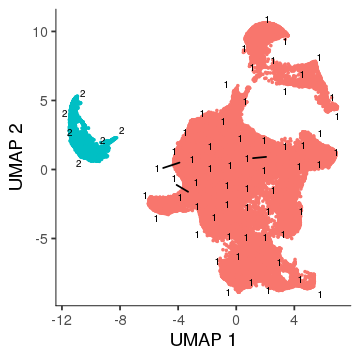

In [250]:
cds <- cluster_cells(cds)
plot_cells(cds, color_cells_by = "partition")

No trajectory to plot. Has learn_graph() been called yet?


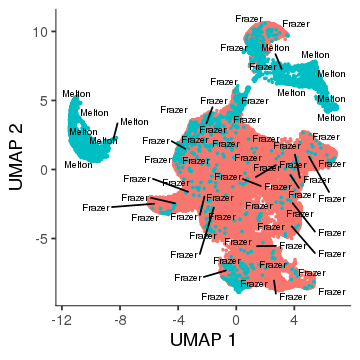

In [251]:
plot_cells(cds, color_cells_by = "study")

In [ ]:
cds <- learn_graph(cds)

In [ ]:
plot_cells(cds, label_groups_by_cluster=FALSE) #,  color_cells_by = "RNA_snn_res.0.3")